<a href="https://colab.research.google.com/github/Manu-Anand/tf_certfication/blob/master/Zero_shot_learning_web_scrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3.1.0
!pip install langdetect

     |████████████████████████████████| 890kB 22.9MB/s 
     |████████████████████████████████| 1.1MB 47.4MB/s 
     |████████████████████████████████| 890kB 50.0MB/s 
     |████████████████████████████████| 3.0MB 47.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=7eedda7cd1a58aa305ec19538cfa4f9d5186ae95ea3feced394de4acec96db7d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 983kB 23.0MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=528225cc0bf8e0f1438fb993597d00fe309ff6f0186d509f37e38f53fd404b3e
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
import csv
import re
import time
import traceback
from urllib.parse import urlparse
import requests
from bs4 import BeautifulSoup
from langdetect import detect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import argmax

from transformers import pipeline

In [ ]:
classifier = pipeline("zero-shot-classification", device=0) # to utilize GPU

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
debug_mode = False
visited_websites = []
MAX_ROWS = 100
cur_no_rows = 0
LANGUAGE = "en"

# defining the googleSearch function
def googleSearch(query):
    # making the url ready for requests
    url = 'https://www.google.com/search?num=100&client=ubuntu&q={}&ie=utf-8&oe=utf-8'.format(query);
    # generating a random user agent using the randomAgent function we previously defined
    user_agent = "Mozilla/5.0 (X11; Linux x86_64; rv:2.0b9pre) Gecko/20110111 Firefox/4.0b9pre"
    print("user agent", user_agent)
    # defining header for the request function
    ran_head = {
        'user-agent': user_agent
    }
	# declaring list g_clean to store the fetched urls
    g_clean = []
    # exception handling code to make sure we don't run into errors
    try:
        # fetching the response using get method in requests
        html = requests.get(url)
        # checking the response status to be success
        if html.status_code == 200:
            # parsing the fetched html in the response using lxml parser in beautiful soup
            soup = BeautifulSoup(html.text, 'lxml')

            # finding all the 'a' tags, links, in the parsed html
            a = soup.find_all('a')
            # looping through the all found a tags for processing
            for i in a:
                # extracting the href attribute for the link to the search results
                k = i.get('href')
                # exception handling code to prevent running into erros
                try:
                    # search for the pattern of a url to prevent unnecessary attributes in the result using re module
                    m = re.search("(?P<url>https?://[^\s]+)", k)
                    # fetching only the url part in the array
                    n = m.group(0)
                    # splitting the url upto the parameters part to get only the necessary url
                    rul = n.split('&')[0]
                    # parsing the url to divide it into components using urlparse
                    domain = urlparse(rul)
                    # checking if the fetched url belongs to google.com if true skip the url
                    if (re.search('google.com', domain.netloc)):
                        continue
                    # else add it to the result list
                    else:
                        g_clean.append(rul)
                except:
                    continue
    except Exception as ex:

        print(traceback.format_exc())
    # finally return the result urls
    finally:
        return g_clean


# grabs the title the headers information from a certain URL
def scrapHTML(url, writer, level=0):
    if("twitter.com" in url):
        print("skipping", url)
        return
    if("youtube.com" in url):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'pdf'):
        print("skipping", url)
        return
    if("pdf" in url):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'jpg'):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'jpeg'):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'png'):
        print("skipping", url)
        return
    if ("download" in url):
        print("skipping", url)
        return
    if ("file" in url):
        print("skipping", url)
        return

    #making sure the website is not scrapped twice
    if url in visited_websites:
        return
    visited_websites.append(url)

    print(url, level)
    # exception handling code to make sure we don't run into errors
    try:
        # fetching the response using get method in requests
        if debug_mode:
            print("............start processing ", url)
        headers =  {
            "User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"
        }
        html = requests.get(url, headers=headers, timeout=10)
        # checking the response status to be success
        soup =  None
        if html.status_code == 200:
            # parsing the fetched html in the response using lxml parser in beautiful soup
            soup = BeautifulSoup(html.content, 'lxml')
            soup.encode("utf-8")
            soup.prettify('utf-8')
            span = soup.find_all('span', limit=300)
            # looping through the all found a tags for processing
            for i in span:
                try:
                    hasChildren = False
                    for child in i.descendants:
                        if (child.name == 'p' or child.name == 'span' or child.name == 'div'):
                            hasChildren = True
                            break

                    if not hasChildren:
                       content = i.get_text(strip=False)
                       if (content.startswith("%PDF-")):
                           print("skipping PDF content", url)
                           return
                       write_content(content, writer, url, level)
                except Exception as exParse:
                    if debug_mode:
                       print("herror on span parsing", exParse)
                    continue

            if debug_mode:
                print("............Step 6 - span extraction : done!")

            p = soup.find_all('p', limit=300)
            # looping through the all found a tags for processing
            for i in p:
                try:
                    hasChildren = False
                    for child in i.descendants:
                        if (child.name == 'p' or child.name == 'span' or child.name == 'div'):
                            hasChildren = True
                            break

                    if not hasChildren:
                        content = i.get_text(strip=False)
                        if(content.startswith("%PDF-")) :
                           print("skipping PDF content", url)
                           return
                        write_content(content, writer, url, level)
                except Exception as exParse:
                    if debug_mode:
                        print("herror on p parsing", exParse)
                    continue

            if debug_mode:
                print("............Step 7 - p extraction : done!")

            divs = soup.find_all('div', limit=300)
            # looping through the all found a tags for processing
            for i in divs:
                try:

                    hasChildren = False
                    for child in i.descendants:
                        if (child.name == 'p' or child.name == 'span' or child.name == 'div'):
                            hasChildren = True
                            break

                    if not hasChildren:
                        content = i.get_text(strip=False)
                        if(content.startswith("%PDF-")) :
                            print("skipping PDF content", url)
                            return
                        write_content(content, writer, url, level)

                except Exception as exParse:
                    if debug_mode:
                        print("herror on div parsing", exParse, url, content)
                        print(traceback.format_exc())
                    continue
            if debug_mode:
                print("............Step 8 - div extraction : done!")

            # only go on second level if wikipedia
            if level == 0 and not ("wikipedia.org" in url):
                return

                # only visit wikipedia pages in the required language
            if level == 1 and not (("https://" + LANGUAGE) in url):
                return

            if level == 0:
                # finding all the 'a' tags, links, in the parsed html
                a = soup.find_all('a')
                # looping through the all found a tags for processing
                for i in a:
                    # extracting the href attribute for the link to the search results
                    k = i.get('href')
                    # exception handling code to prevent running into erros
                    try:
                        # search for the pattern of a url to prevent unnecessary attributes in the result using re module
                        m = re.search("(?P<url>https?://[^\s]+)", k)
                        # fetching only the url part in the array
                        n = m.group(0)
                        # splitting the url upto the parameters part to get only the necessary url
                        rul = n.split('&')[0]
                        # parsing the url to divide it into components using urlparse
                        domain = urlparse(rul)
                        # checking if the fetched url belongs to google.com if true skip the url
                        if (re.search('google.com', domain.netloc)):
                            continue
                        # else add it to the result list
                        else:
                            if not(check_same_domain(url, rul)) :
                                scrapHTML(rul, writer, 1)
                    except Exception as ex:
                        continue

    except Exception as ex:
       if debug_mode:
          print(ex)
          print(traceback.format_exc())

def get_csv_file_name(text_query):
    return '/content/google_results.csv'

def check_same_domain(url, other_url):
    #remove the protocol
    url = url.replace("https://", "")

    cut_here = url.find("/")
    if cut_here == -1:
        cut_here = url.find("?")

    if(cut_here > 0):
        url = url[0:cut_here]

    result = False
    if url in other_url:
        result = True

    return result


# writes the text into the csv file
def write_content(content, writer, url, level):
    # remove links from text
    content = re.sub(r'^https?:\/\/.*[\r\n]*', '', content, flags=re.MULTILINE)

    # if a longer phrase
    if len(content) > 150 and detect(content) == LANGUAGE:
        content = content.replace('\n', ' ').replace('\r', ' ')
        writer.writerow({'content': content.strip(), 'url': url, 'type': 'content', 'level': level})

In [ ]:
text_query = 'climate fight'

startTime = time.time()
googleResults = googleSearch(text_query)
with open(get_csv_file_name(text_query), 'w', newline='', encoding="utf-8") as file:
    fieldnames = ['content', 'url', 'type', 'level']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for resultURL in googleResults:
        url_content= scrapHTML(resultURL, writer)
        duration = time.time() - startTime

duration = time.time() - startTime
print(duration)

user agent Mozilla/5.0 (X11; Linux x86_64; rv:2.0b9pre) Gecko/20110111 Firefox/4.0b9pre
https://www.edf.org/climate/why-fighting-climate-change-so-urgent 0
https://www.activesustainability.com/climate-change/6-actions-to-fight-climate-change/ 0
https://www.worldwildlife.org/pages/what-you-can-do-to-fight-climate-change 0
https://www.un.org/sustainabledevelopment/climate-change/ 0
https://qz.com/1915134/five-things-individuals-can-do-to-fight-climate-change/ 0
https://www.bbc.com/news/science-environment-54347878 0
https://archive.curbed.com/2017/6/7/15749900/how-to-stop-climate-change-actions 0
https://www.theguardian.com/us-news/2020/jul/27/global-climate-fight-could-be-lost-trump-re-elected 0
https://time.com/5669038/women-climate-change-leaders/ 0
https://www.greenbiz.com/article/rbg-left-these-4-lessons-climate-fight 0
https://e360.yale.edu/features/coronavirus-holds-key-lessons-on-how-to-fight-climate-change 0
https://e360.yale.edu/features/why-keeping-mature-forests-intact-is-key

In [ ]:
#df = pd.read_csv('/content/google_results.csv', usecols=['content'], nrows=50)
df = pd.read_csv('/content/google_results.csv', usecols=['content'])
df.shape

(1981, 1)

In [ ]:
for sent in df['content'].values:
  print(sent)
  print()

We humans are the ones who burn fossil fuels and chop down forests, causing average temperatures to rise worldwide. That global warming trend is increasingly disrupting our climate — the average weather over many years.

A warmer world — even by a half-degree Celsius — has more evaporation, leading to more water in the atmosphere. Such changing conditions put our agriculture, health, water supply and more at risk.

Picture a North Carolina cotton farm that’s been around since 1960, with global average temperatures rising by roughly half a degree since it grew its first crop.

Then a hurricane like 2018’s Florence — already strengthened by warmer oceans and higher seas — dumps this excess rainfall on the farm. The crops get more flooded and damaged than they did half a century ago.

Whether it’s a shift of 1.5 degrees or 2 degrees, these warming levels aren’t magic thresholds. Every rise in warming is worse for the planet than the last.

Environmental Defense Fund is a nonprofit, tax-ex

In [ ]:
candidate_labels = ["renewable", "politics", "emission", "temperature", "emergency", "advertisment"]
candidate_results = [0, 0, 0, 0, 0, 0]

for sent in df['content'].values:
    # To do multi-class classification, simply pass multi_class=True.
    # In this case, the scores will be independent, but each will fall between 0 and 1.
    res = classifier(sent, candidate_labels)

    SCORES = res["scores"]
    CLASSES = res["labels"]
    BEST_INDEX = argmax(SCORES)
    predicted_class = CLASSES[BEST_INDEX]
    predicted_score = SCORES[BEST_INDEX]

    if predicted_class == 'renewable' and predicted_score > 0.5:
        candidate_results[0] = candidate_results[0] + 1
    if predicted_class == 'politics' and predicted_score > 0.5:
        candidate_results[1] = candidate_results[1] + 1
    if predicted_class == 'emission' and predicted_score > 0.5:
        candidate_results[2] = candidate_results[2] + 1
    if predicted_class == 'temperature' and predicted_score > 0.5:
        candidate_results[3] = candidate_results[3] + 1
    if predicted_class == 'emergency' and predicted_score > 0.5:
        candidate_results[4] = candidate_results[4] + 1
    if predicted_class == 'advertisment' and predicted_score > 0.5:
        candidate_results[5] = candidate_results[5] + 1

    if res['scores'][0] > 0.5:
        print(sent)
        print(res['labels'])
        print(res['scores'])
        print()

print(candidate_results)

We humans are the ones who burn fossil fuels and chop down forests, causing average temperatures to rise worldwide. That global warming trend is increasingly disrupting our climate — the average weather over many years.
['temperature', 'emission', 'emergency', 'advertisment', 'politics', 'renewable']
[0.7294215559959412, 0.23263096809387207, 0.022281786426901817, 0.01040672417730093, 0.003110054647549987, 0.0021489716600626707]

A warmer world — even by a half-degree Celsius — has more evaporation, leading to more water in the atmosphere. Such changing conditions put our agriculture, health, water supply and more at risk.
['temperature', 'emergency', 'advertisment', 'emission', 'renewable', 'politics']
[0.850939154624939, 0.06385958194732666, 0.038118407130241394, 0.02592185139656067, 0.010956985875964165, 0.010204019024968147]

Picture a North Carolina cotton farm that’s been around since 1960, with global average temperatures rising by roughly half a degree since it grew its first cr

In [ ]:
data = {'labels': candidate_labels,
        'values': candidate_results}

df_chart = pd.DataFrame(data, columns=['labels','values'])

df_chart.head(10)

,labels,values
0,renewable,84
1,politics,133
2,emission,431
3,temperature,97
4,emergency,77
5,advertisment,21


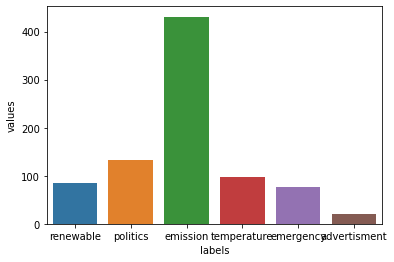

In [ ]:
sns.barplot(data = df_chart
            ,x = 'labels'
            ,y = 'values'
            )

In [ ]:

candidate_labels = ["renewable", "politics", "emission", "temperature", "emergency", "advertisment"]
candidate_results = [0, 0, 0, 0, 0, 0]

for sent in df['content'].values:
    # To do multi-class classification, simply pass multi_class=True.
    # In this case, the scores will be independent, but each will fall between 0 and 1.
    res = classifier(sent, candidate_labels, multi_class=True)

    print_flag = 0
    for index, score in enumerate(res['scores']):
      if score > 0.5:
        if res['labels'][index] == 'renewable':
          candidate_results[0] = candidate_results[0] + 1
        if res['labels'][index] == 'politics':
          candidate_results[1] = candidate_results[1] + 1
        if res['labels'][index] == 'emission':
          candidate_results[2] = candidate_results[2] + 1
        if res['labels'][index] == 'temperature':
          candidate_results[3] = candidate_results[3] + 1
        if res['labels'][index] == 'emergency':
          candidate_results[4] = candidate_results[4] + 1
        if res['labels'][index] == 'advertisment':
          candidate_results[5] = candidate_results[5] + 1
        
        if print_flag == 0:
          print(sent)
          print(res['labels'])
          print(res['scores'])
          print()
          print_flag = 1

print(candidate_results)

We humans are the ones who burn fossil fuels and chop down forests, causing average temperatures to rise worldwide. That global warming trend is increasingly disrupting our climate — the average weather over many years.
['temperature', 'emission', 'emergency', 'advertisment', 'politics', 'renewable']
[0.9956424236297607, 0.9723935127258301, 0.6582565903663635, 0.04984989017248154, 0.004896942991763353, 0.00037367938784882426]

A warmer world — even by a half-degree Celsius — has more evaporation, leading to more water in the atmosphere. Such changing conditions put our agriculture, health, water supply and more at risk.
['temperature', 'emergency', 'advertisment', 'emission', 'politics', 'renewable']
[0.9474199414253235, 0.5346571207046509, 0.040377289056777954, 0.019207287579774857, 0.0027163524646312, 0.0016012100968509912]

Picture a North Carolina cotton farm that’s been around since 1960, with global average temperatures rising by roughly half a degree since it grew its first crop

In [ ]:
data = {'labels': candidate_labels,
        'values': candidate_results}

df_chart = pd.DataFrame(data, columns=['labels','values'])

df_chart.head(10)

,labels,values
0,renewable,137
1,politics,253
2,emission,479
3,temperature,158
4,emergency,182
5,advertisment,17


In [ ]:
sns.barplot(data = df_chart
            ,x = 'labels'
            ,y = 'values'
            )